# **LIBRARY**

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import InceptionV3, EfficientNetB3

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# **LOAD DATA**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
directory = "/content/drive/MyDrive/SKRIPSI/Dataset"
files = os.listdir(directory)
print(files)

['pituitary_tumor', 'no_tumor', 'meningioma_tumor', 'glioma_tumor']


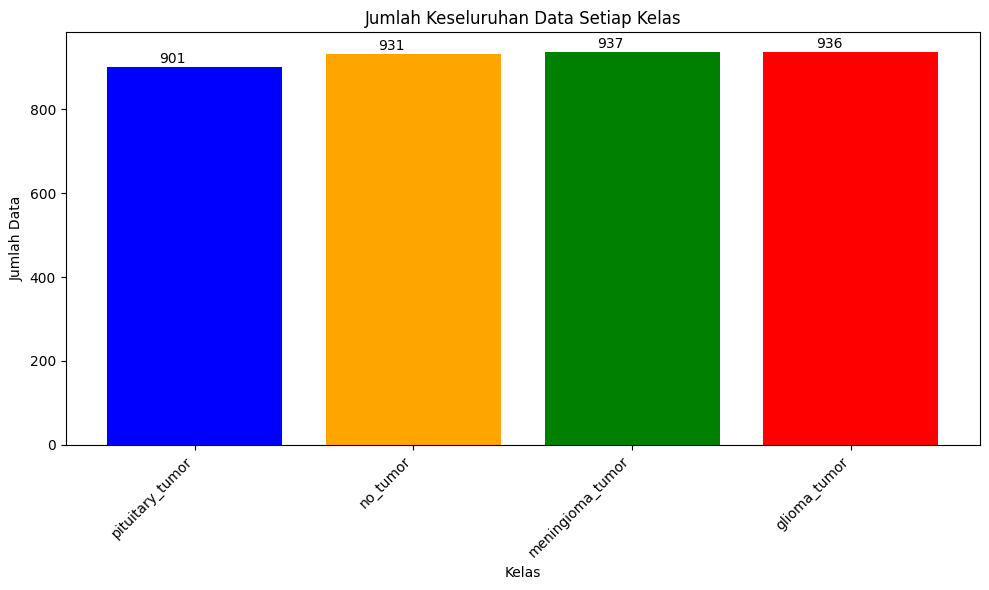

In [4]:
def count_files_in_class(class_path):
    num_files = len([file for file in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, file))])
    return num_files

def count_files_in_directory(directory):
    class_folders = os.listdir(directory)
    class_counts = {}
    total_count = 0
    for class_folder in class_folders:
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            class_count = count_files_in_class(class_path)
            class_counts[class_folder] = class_count
            total_count += class_count
    return total_count, class_counts

total_count, class_counts = count_files_in_directory(directory)
colors = ['blue', 'orange', 'green', 'red']
class_names = list(class_counts.keys())

plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.title('Jumlah Keseluruhan Data Setiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.xticks(rotation=45, ha='right')

for bar, count in zip(bars, class_counts.values()):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 10, count, ha='center', color='black')

plt.tight_layout()
plt.show()

# **SPLITTING DATA**

In [5]:
train_dir = "/content/drive/MyDrive/SKRIPSI/dataset_split/train"
test_dir = "/content/drive/MyDrive/SKRIPSI/dataset_split/test"
val_dir = "/content/drive/MyDrive/SKRIPSI/dataset_split/val"

In [6]:
def count_files_in_class(class_path):
    num_files = len([file for file in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, file))])
    return num_files

In [7]:
def count_files_in_path(path):
    class_folders = os.listdir(path)
    class_counts = {}
    total_count = 0
    for class_folder in class_folders:
        class_path = os.path.join(path, class_folder)
        if os.path.isdir(class_path):
            class_count = count_files_in_class(class_path)
            class_counts[class_folder] = class_count
            total_count += class_count
    return total_count, class_counts

In [8]:
train_total, train_class_counts = count_files_in_path(train_dir)
test_total, test_class_counts = count_files_in_path(test_dir)
val_total, val_class_counts = count_files_in_path(val_dir)

print("Jumlah data/gambar di setiap path:")
print(f"Train: {train_total}")
print(f"Test: {test_total}")
print(f"Validation: {val_total}")
print("\nJumlah data/gambar dalam setiap kelas:")
print("Train:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count}")
print("\nTest:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")
print("\nValidation:")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count}")

Jumlah data/gambar di setiap path:
Train: 2591
Test: 374
Validation: 740

Jumlah data/gambar dalam setiap kelas:
Train:
pituitary_tumor: 630
no_tumor: 651
meningioma_tumor: 655
glioma_tumor: 655

Test:
pituitary_tumor: 91
no_tumor: 94
meningioma_tumor: 95
glioma_tumor: 94

Validation:
pituitary_tumor: 180
no_tumor: 186
meningioma_tumor: 187
glioma_tumor: 187


In [9]:
def display_one_sample(directory):
    plt.figure(figsize=(12, 6))
    class_folders = os.listdir(directory)

    for i, class_folder in enumerate(class_folders):
        class_path = os.path.join(directory, class_folder)
        class_images = os.listdir(class_path)
        sample_image = random.choice(class_images)

        image_path = os.path.join(class_path, sample_image)
        img = plt.imread(image_path)
        plt.subplot(1, len(class_folders), i + 1)
        plt.imshow(img)
        plt.title(class_folder)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

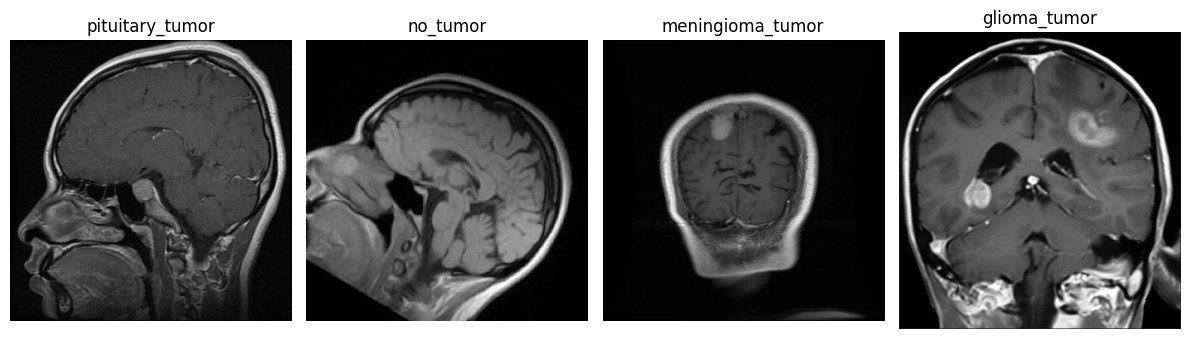

In [10]:
display_one_sample(train_dir)

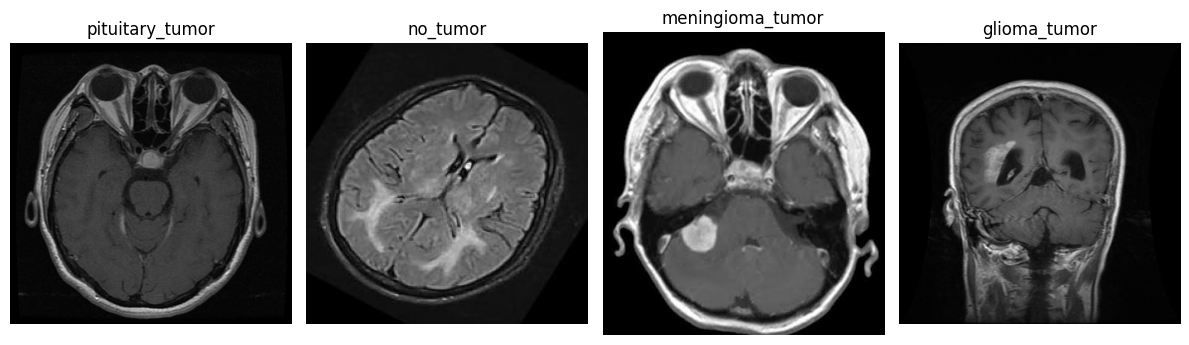

In [11]:
display_one_sample(test_dir)

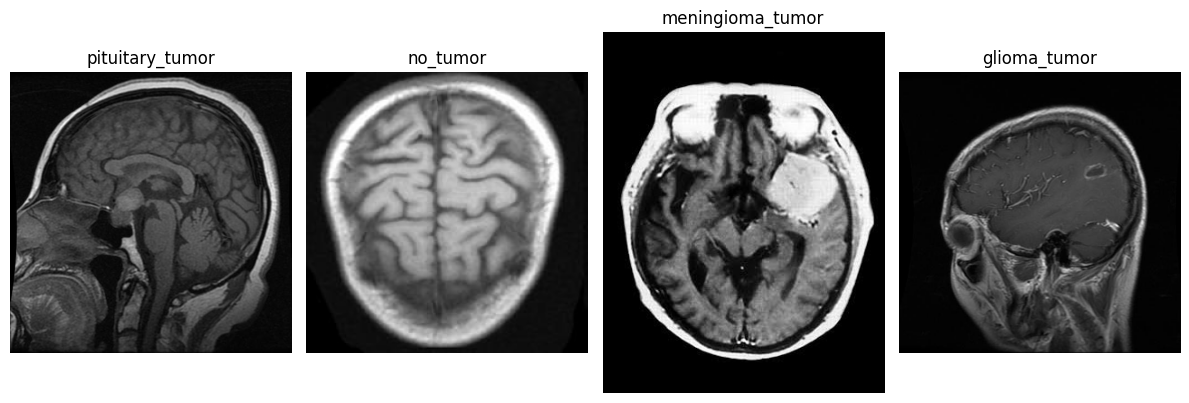

In [12]:
display_one_sample(val_dir)

# **AUGMENTASI DATA**

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.4,
    zoom_range=0.2,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

In [14]:
img_height = 299
img_width = 299
batch_size= 64
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode = 'categorical',
    shuffle = False,
)

Found 2591 images belonging to 4 classes.
Found 740 images belonging to 4 classes.
Found 374 images belonging to 4 classes.


# **MODELING**

## **INCEPTION V3**

In [15]:
pre_model = InceptionV3(
        input_shape=(299,299,3),
        weights='imagenet',
        include_top=False,
)
for layers in pre_model.layers:
    layers.trainable=False

last_layer = pre_model.get_layer('mixed7')
last_output = last_layer.output

87910968/87910968 [==============================] - 0s 0us/step


In [16]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(4,activation='softmax')(x)

model = Model(pre_model.input,output)

model.compile(optimizer=Adam(learning_rate=0.0001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy']
)

In [17]:
# class myCallbacks(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         if logs.get('val_accuracy') > 0.91 and logs.get('accuracy') > 0.91:
#             self.model.stop_training = True


class myCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        pass


In [18]:
# model.fit(
#     train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size),
#     epochs=30,
#     validation_data=val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size=batch_size),
#     steps_per_epoch=len(train_generator),
#     callbacks=[myCallbacks()]
# )


model.fit(
    train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size),
    epochs=30,
    validation_data=val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size=batch_size),
    steps_per_epoch=len(train_generator)
)


Found 2591 images belonging to 4 classes.
Found 740 images belonging to 4 classes.
Epoch 1/30
41/41 [==============================] - 1027s 25s/step - loss: 0.8985 - accuracy: 0.6503 - val_loss: 1.3508 - val_accuracy: 0.4865
Epoch 2/30
41/41 [==============================] - 114s 3s/step - loss: 0.5190 - accuracy: 0.8097 - val_loss: 0.8580 - val_accuracy: 0.6905
Epoch 3/30
41/41 [==============================] - 90s 2s/step - loss: 0.4426 - accuracy: 0.8375 - val_loss: 0.5877 - val_accuracy: 0.8014
Epoch 4/30
41/41 [==============================] - 112s 3s/step - loss: 0.3612 - accuracy: 0.8703 - val_loss: 0.5764 - val_accuracy: 0.7932
Epoch 5/30
41/41 [==============================] - 91s 2s/step - loss: 0.3463 - accuracy: 0.8695 - val_loss: 0.4663 - val_accuracy: 0.8378
Epoch 6/30
41/41 [==============================] - 95s 2s/step - loss: 0.3111 - accuracy: 0.8850 - val_loss: 0.3698 - val_accuracy: 0.8878
Epoch 7/30
41/41 [==============================] - 91s 2s/step - loss: 

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

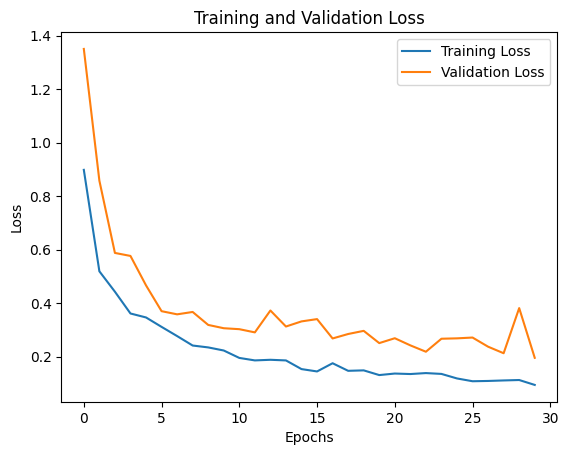

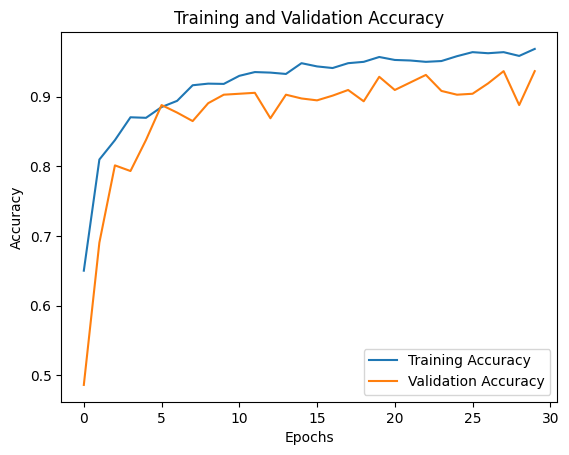

In [20]:
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
testLab = test_generator.classes
pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis=-1)
class_names = test_generator.class_indices

print(classification_report(y_pred, testLab, target_names=class_names))

6/6 [==============================] - 129s 25s/step
                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.96      0.94        91
meningioma_tumor       0.91      0.89      0.90        97
        no_tumor       0.98      0.99      0.98        93
 pituitary_tumor       0.97      0.95      0.96        93

        accuracy                           0.94       374
       macro avg       0.94      0.94      0.94       374
    weighted avg       0.94      0.94      0.94       374



6/6 [==============================] - 2s 402ms/step


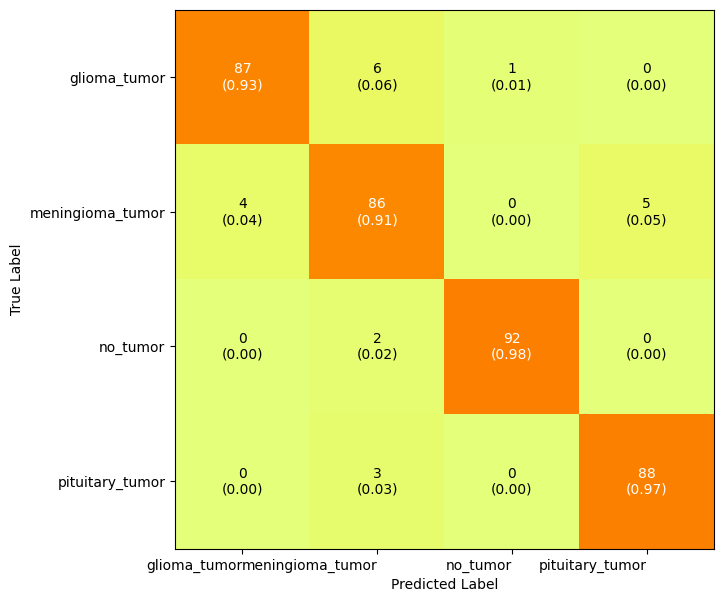

In [22]:
pred = model.predict(test_generator)

y_pred_class = np.argmax(pred, axis=1)
y_test_class = test_generator.classes

cm = confusion_matrix(y_test_class, y_pred_class)

plot_confusion_matrix(conf_mat=cm, figsize=(8, 7), class_names=list(test_generator.class_indices.keys()), show_normed=True, cmap='Wistia')
plt.xticks(rotation=0, alpha=1.0, color='black')
plt.yticks(alpha=1.0, color='black')
plt.xlabel("Predicted Label", color="black")
plt.ylabel("True Label", color="black")
plt.show()